# Loading Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [2]:
%matplotlib inline
import pandas as pd
import os, cv2
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from skimage.measure import regionprops
from sklearn import preprocessing

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm
from skimage.io import imread
from matplotlib.pyplot import imread

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Loading Dataset

In [3]:
def load_data_original_signatures(data_dir):
    for img in tqdm(os.listdir(data_dir)):
        if(img.endswith(".png")):
          path = os.path.join(data_dir,img)
          labels_original.append(str(img))
          img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
          data_original.append(img)

def load_data_forged_signatures(data_dir):
    for img in tqdm(os.listdir(data_dir)):
      if(img.endswith(".png")):
        path = os.path.join(data_dir,img)
        labels_forged.append(str(img))
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        data_forged.append(img)

In [4]:
original_signatures = '/content/drive/MyDrive/BTP/CEDAR/full_org'
forged_signatures = '/content/drive/MyDrive/BTP/CEDAR/full_forg'

In [5]:
data_original = []
data_forged = []
labels_original = []
labels_forged = []

load_data_original_signatures(original_signatures)
load_data_forged_signatures(forged_signatures)

100%|██████████| 1321/1321 [00:27<00:00, 47.86it/s] 


In [6]:
data_original = np.array(data_original)
data_forged = np.array(data_forged)

<ipython-input-6-fa221fb6123a>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_original = np.array(data_original)
<ipython-input-6-fa221fb6123a>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_forged = np.array(data_forged)


# Preprocessing

## Binarizing Image

In [7]:
def binarization(img):
  (thresh, im_bw) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  return np.invert(im_bw)

## Cropping Image

In [8]:
def crop_image(img,tol=0):
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

## Resizing Image

In [9]:
def resize_image(img):
  img = cv2.resize(img, (224, 224))
  return img

## Combining all preprocessing techniques

In [10]:
for i in range(len(data_original)):
  img = data_original[i]
  binarized_img = binarization(img)
  cropped_img = crop_image(binarized_img)
  resized_img = resize_image(cropped_img)
  data_original[i] = resized_img

In [11]:
for i in range(len(data_forged)):
  img = data_forged[i]
  binarized_img = binarization(img)
  cropped_img = crop_image(binarized_img)
  resized_img = resize_image(cropped_img)
  data_forged[i] = resized_img

# Preparing data

In [12]:
x_train = np.zeros((1,224,224,3))
y_train = np.zeros((1,))

for i in range(1,45):
  person_original_mask = np.char.startswith(labels_original, "original_" + str(i) + "_")
  person_forged_mask = np.char.startswith(labels_forged, "forgeries_" + str(i) + "_")
  person_original_signatures = data_original[person_original_mask]
  person_forged_signatures = data_forged[person_forged_mask]

  for j in range(24):
    stacked_img = np.dstack((person_original_signatures[j], person_original_signatures[j], person_original_signatures[j]))
    input_img = np.expand_dims(stacked_img, axis = 0)
    x_train = np.append(x_train,input_img,axis = 0)
    y_train = np.append(y_train,1)

  for j in range(24):
    stacked_img = np.dstack((person_forged_signatures[j], person_forged_signatures[j], person_forged_signatures[j]))
    input_img = np.expand_dims(stacked_img, axis = 0)
    x_train = np.append(x_train,input_img,axis = 0)
    y_train = np.append(y_train, 0)

In [13]:
x_test = np.zeros((1,224,224,3))

for i in range(44,56):
  person_original_mask = np.char.startswith(labels_original, "original_" + str(i) + "_")
  person_forged_mask = np.char.startswith(labels_forged, "forgeries_" + str(i) + "_")
  person_original_signatures = data_original[person_original_mask]
  person_forged_signatures = data_forged[person_forged_mask]

  for j in range(24):
    stacked_img = np.dstack((person_original_signatures[j], person_original_signatures[j], person_original_signatures[j]))
    input_img = np.expand_dims(stacked_img, axis = 0)
    x_test = np.append(x_test, input_img, axis = 0)

  for j in range(24):
    stacked_img = np.dstack((person_forged_signatures[j], person_forged_signatures[j], person_forged_signatures[j]))
    input_img = np.expand_dims(stacked_img, axis = 0)
    x_test = np.append(x_test, input_img, axis = 0)

# Classification using VGG16

In [14]:
import tensorflow as tf
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224,3))

for layer in base_model.layers:
	layer.trainable = False

last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2, activation='sigmoid')(x)

model = tf.keras.Model(base_model.input, x)
model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])

58889256/58889256 [==============================] - 0s 0us/step


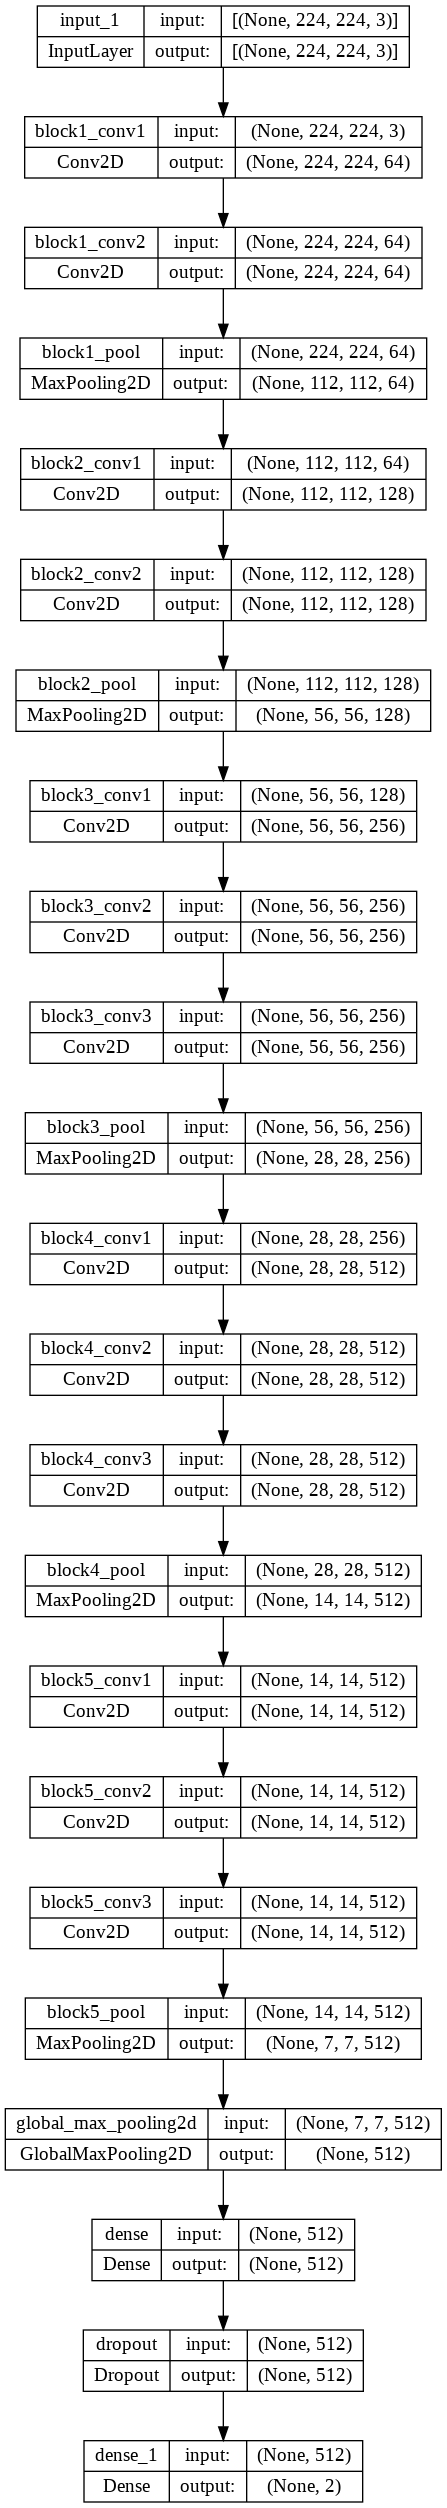

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/BTP/model.png', show_shapes=1, show_layer_names=1)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
vgg_classifier = model.fit(x_train,y_train,epochs = 3, validation_split = 0.2, shuffle=True)

Epoch 1/3
53/53 [==============================] - 1104s 21s/step - loss: 11.1042 - acc: 0.6391 - val_loss: 5.3735 - val_acc: 0.6336
Epoch 2/3
53/53 [==============================] - 1105s 21s/step - loss: 2.8186 - acc: 0.7562 - val_loss: 2.7157 - val_acc: 0.6265
Epoch 3/3
53/53 [==============================] - 1091s 21s/step - loss: 0.9971 - acc: 0.7893 - val_loss: 1.3957 - val_acc: 0.6619


# Using Flask

In [17]:
# from flask import Flask, request, jsonify

In [18]:
# !pip install flask-ngrok

In [19]:
# from flask_ngrok import run_with_ngrok
# app = Flask(__name__)
# run_with_ngrok(app)

In [20]:
# @app.route('/api',methods=['POST'])
# def predict():
#     data = request.get_json(force=True)
#     prediction = model.predict([[np.array(data['exp'])]])
#     output = prediction[0]
#     return jsonify(output)

In [21]:
# @app.route('/')
# def home():
#     return "<h1>Hello</h1>"

In [22]:
# if __name__ == '__main__':
#   app.run()

# Using Request

In [23]:
# import requests
# url = 'http://localhost:5000/api'
# r = requests.post(url,json={'exp':1.8,})
# print(r.json())